# Time Series Analysis 

In the broadest definition, a time series is any data set where the values are measured at different points in time. Many time series are uniformly spaced at a specific frequency, for example, hourly weather measurements, daily counts of web site visits, or monthly sales totals. Time series can also be irregularly spaced and sporadic, for example, timestamped data in a computer system’s event log or a history of 911 emergency calls. Pandas time series tools apply equally well to either type of time series.

The study of time series has arisen because certain sorts of data streams are heavily dependent on the flow of time. Of course, we have not totally ignored time as a feature up to this point. The selling price of a house probably does have some relation to the season or the year as real estate markets grow and decline with certain temporally-indexed economic changes etc. But surely time is not the most important predictor of house price. Square footage would likely be more strongly correlated with price than would date of sale.

But there are other sorts of data that more readily lend themselves to a temporal analysis. One canonical example is numbers from a stock exchange: First, data from stock tickers often arrive as numbers anchored to consecutive units of time. I get the selling price for some stock on January 1, say, and the next bit of information I gain will be the selling price for that stock on January 2. (We'll explore this feature of time series below.) Second, and more important, if I'm interested in actually predicting the selling price of a stock for, say, tomorrow, then very likely one piece of very salient (i.e. correlated) information would be the selling price of that stock today.

Other examples of this sort of time-dependent data:

    * Births/day or year in countries
    
    * Current trends: Census data/Covid-19/Airline/Zoom stocks/Bitcoin 
    
    * Sales of products

In [1]:
# Let's load some packages.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Define a function that will help us load and
# clean up a dataset.

def load_trend(trend_name='football', country_code='us'):
    df = pd.read_csv('data/google-trends_'
                     + trend_name + '_'
                     + country_code
                     + '.csv').iloc[1:, :]
    df.columns = ['counts']
    df['counts'] = df['counts'].str.replace('<1', '0').astype(int)
    return df

In [3]:
df = load_trend(**{'trend_name': 'data-science', 'country_code': 'us'})

The `**` syntax is used to pass keywords and values in dictionary form to a function. For more on `*` and `**` (`*args` and `**kwargs`), see [this page](https://www.geeksforgeeks.org/args-kwargs-python/).

In [4]:
trends = [
    {'trend_name': 'data-science', 'country_code': 'us'},
    {'trend_name': 'football', 'country_code': 'us'},
    {'trend_name': 'football', 'country_code': 'uk'},
    {'trend_name': 'game-of-thrones', 'country_code': 'us'},
    {'trend_name': 'pokemon', 'country_code': 'us'},
    {'trend_name': 'taxes', 'country_code': 'us'},   
]

In [5]:
np.random.shuffle(trends)

In [6]:
trend_dfs = [load_trend(**trend) for trend in trends]

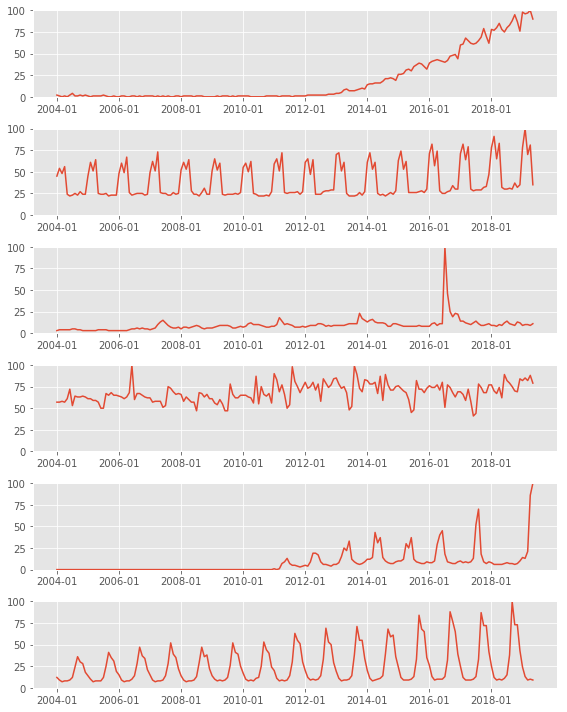

In [7]:
# Let's see if we can guess which is which just by looking
# at their graphs.

import matplotlib; matplotlib.style.use('ggplot')

fig, axs = plt.subplots(len(trend_dfs), 1, figsize=(8, 10))
plt.tight_layout()
for i, trend_df in enumerate(trend_dfs):
    ax = axs[i]
    #ax.set_title(str(trends[i]))
    ax.plot(np.array(trend_df.index), trend_df['counts'])
    ticks = ax.get_xticks()
    ax.set_ylim((0, 100))
    ax.set_xticks([tick for tick in ticks if tick%24 == 0])

## Working with Time Series Data 
    - Datetime Objects 
    - Sampling 

In [8]:
# Load and display
df_temp = pd.read_csv("min_temp.csv")
display(df_temp.head(20))
display(df_temp.info())

,Date,Daily_min
0,1/1/81,20.7
1,2/1/81,17.9
2,3/1/81,18.8
3,4/1/81,14.6
4,5/1/81,15.8
5,6/1/81,15.8
6,7/1/81,15.8
7,8/1/81,17.4
8,9/1/81,21.8
9,10/1/81,20.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
Date         3650 non-null object
Daily_min    3650 non-null float64
dtypes: float64(1), object(1)
memory usage: 57.1+ KB


None

### Make data readable as a datetime

First, you want to make sure:
- Dates are in the index of the DataFrame (helps you with plotting)
- That we change the dates in our dataset from "non-null object" to "non-null datetime" (i.e., change the data type of dates). This can be done using the `to_datetime()` function from Pandas. To make sure Python understands the date correctly, a `format` argument can be passed [as specified in the documentation](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#providing-a-format-argument).

#### Datetime Objects

These comprise a nice standard way of dealing with times and dates in Python. There is a `datetime` [library](https://docs.python.org/2/library/datetime.html), and inside `pandas` there is a `datetime` module as well as a `to_datetime()` function.

In [9]:
import datetime
datetime.datetime(2020, 12, 31)

datetime.datetime(2020, 12, 31, 0, 0)

**Datetime objects have the parts of a date as attributes**

In [10]:
now = datetime.datetime(2020, 12, 31)

In [11]:
print(now.year)
print(now.month)
print(now.day)
print(now.hour)

2020
12
31
0


`.timedelta()`

In [12]:
moment = datetime.timedelta(minutes=100)
moment.days

0

In [13]:
moment.seconds

6000

In [14]:
pd.to_datetime('2020-12-31')

Timestamp('2020-12-31 00:00:00')

In [15]:
pd.to_datetime(['2020-12-30', '2020-12-31'], format='%Y-%m-%d')

DatetimeIndex(['2020-12-30', '2020-12-31'], dtype='datetime64[ns]', freq=None)

**Let's convert our weather data now**

In [16]:
# Creating a proper datetime using the string formatting
df_temp['Date'] = pd.to_datetime(df_temp['Date'], format='%d/%m/%y')

# Make the temporal data as the focus
df_temp = df_temp.set_index('Date')

In [17]:
display(df_temp.head(10))
display(df_temp.info())

,Daily_min
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
1981-01-06,15.8
1981-01-07,15.8
1981-01-08,17.4
1981-01-09,21.8


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
Daily_min    3650 non-null float64
dtypes: float64(1)
memory usage: 57.0 KB


None

In [18]:
#a simple slice helps to define the range of interest 
after_1990 = df_temp['1990':]
display(after_1990.head(15))

,Daily_min
Date,
1990-01-01,14.8
1990-01-02,13.3
1990-01-03,15.6
1990-01-04,14.5
1990-01-05,14.3
1990-01-06,15.3
1990-01-07,16.4
1990-01-08,14.8
1990-01-09,17.4


### Resampling Methods 

Resampling involves changing the frequency of your time series observations. 
Two types of resampling are: 

**Upsampling:** Where you increase the frequency of the samples, such as from minutes to seconds.<br/> 
**Downsampling:** Where you decrease the frequency of the samples, such as from days to months

In both cases, data must be invented. Assume we have a temperature sensor which takes measurements every minute. If we do not need to have a minute-level precision, we can take the average of 60 minute measurements in an hour and show the changes in the temperature hourly. This is down-sampling which means converting to a lower frequency.

Resampling can be done using **resample()** or **asfreq()** functions.
- **Resample(Downsampling):** Aggregates data based on specified frequency and aggregation function. Downsampling resamples at a lower rate, you may loose information but its more computationally efficient
![](https://miro.medium.com/max/453/1*60Xzg45SRqJhFueqtOlQ8Q.png)
- **Asfreq(Upsampling):** Selects data based on the specified frequency and returns the value at the end of the specified interval.




#### Downsampling 


In [19]:
# Average out so we have monthly means (compared to using days)
monthly = df_temp.resample('MS')
month_mean = monthly.mean()

In [20]:
print(month_mean.head(10))
print(df_temp.head(10))

            Daily_min
Date                 
1981-01-01  17.712903
1981-02-01  17.678571
1981-03-01  13.500000
1981-04-01  12.356667
1981-05-01   9.490323
1981-06-01   7.306667
1981-07-01   7.577419
1981-08-01   7.238710
1981-09-01  10.143333
1981-10-01  10.087097
            Daily_min
Date                 
1981-01-01       20.7
1981-01-02       17.9
1981-01-03       18.8
1981-01-04       14.6
1981-01-05       15.8
1981-01-06       15.8
1981-01-07       15.8
1981-01-08       17.4
1981-01-09       21.8
1981-01-10       20.0


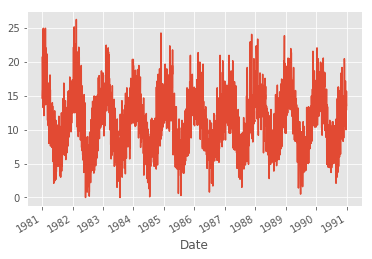

In [21]:
df_temp['Daily_min'].plot()

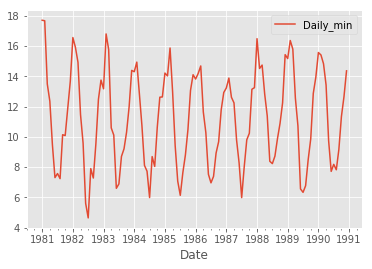

In [22]:
df_temp.resample('M').mean().plot()

#### Upsampling

Up-sampling is the opposite of down-sampling. The frequency is increased. When we increase the frequency, there will be some missing data.We can leave these missing values blank (missing) or select a method to fill these missing values such as forward fill or backward fill.

    - ffill() function is used to fill the missing value in the dataframe. 'ffill' stands for 'forward fill' and will propagate last valid observation forward
    - bfill() is used to backward fill the missing values in the dataset. It will backward fill the NaN values that are present in the pandas dataframe.

In [23]:
# Data to every 12hours but only fill the parts known (blank otherwise)
bidaily = df_temp.resample('12H').asfreq()
bidaily.head(10)

,Daily_min
Date,
1981-01-01 00:00:00,20.7
1981-01-01 12:00:00,NaN
1981-01-02 00:00:00,17.9
1981-01-02 12:00:00,NaN
1981-01-03 00:00:00,18.8
1981-01-03 12:00:00,NaN
1981-01-04 00:00:00,14.6
1981-01-04 12:00:00,NaN
1981-01-05 00:00:00,15.8


In [24]:
# Interpolate to every 12hours but fill the parts unknown (no blanks)
bidaily = df_temp.resample('12H').ffill()
bidaily.head(10)

,Daily_min
Date,
1981-01-01 00:00:00,20.7
1981-01-01 12:00:00,20.7
1981-01-02 00:00:00,17.9
1981-01-02 12:00:00,17.9
1981-01-03 00:00:00,18.8
1981-01-03 12:00:00,18.8
1981-01-04 00:00:00,14.6
1981-01-04 12:00:00,14.6
1981-01-05 00:00:00,15.8


In [25]:
hourly = df_temp.resample('1H').ffill()
hourly.head(30)

,Daily_min
Date,
1981-01-01 00:00:00,20.7
1981-01-01 01:00:00,20.7
1981-01-01 02:00:00,20.7
1981-01-01 03:00:00,20.7
1981-01-01 04:00:00,20.7
1981-01-01 05:00:00,20.7
1981-01-01 06:00:00,20.7
1981-01-01 07:00:00,20.7
1981-01-01 08:00:00,20.7


## Trends 

The trends represent an increase or decrease in time-series value over time.

### Upward
![](https://github.com/learn-co-students/dsc-3-25-05-types-of-trends-online-ds-sp-000/raw/master/index_files/index_15_0.png)

### Downward
![](https://github.com/learn-co-students/dsc-3-25-05-types-of-trends-online-ds-sp-000/raw/master/index_files/index_19_0.png)

### Exponential
![](https://github.com/learn-co-students/dsc-3-25-05-types-of-trends-online-ds-sp-000/raw/master/index_files/index_22_0.png)

### Periodic 
![](https://github.com/learn-co-students/dsc-3-25-05-types-of-trends-online-ds-sp-000/raw/master/index_files/index_25_0.png)
![](https://github.com/learn-co-students/dsc-3-25-05-types-of-trends-online-ds-sp-000/raw/master/index_files/index_30_0.png)

## Stationarity 

A time series is said to be stationary if its statistical properties such as mean, variance, etc. remain constant over time. Stationarity is important because most time series models work on the assumption that the time series are stationary. [Learn.co](https://learn.co/tracks/module-4-data-science-career-2-1/big-data-deep-learning-and-natural-language-processing/section-37-working-with-time-series-data/types-of-trends)

There are 2 main ways to evaluate if a time series is nonstationary:

- Seeing whether the time series contains a _trend_ 
    - A positive or negative trend indicates nonstationarity 
- Seeing whether the _variance_ changes over time
    - If the plot shows increasingly large or small fluctuations over time - that points to fluctuating variance

Which of these series are stationary? 
![](https://otexts.com/fpp2/fpp_files/figure-html/stationary-1.png)

Figure above:
(a) Google stock price for 200 consecutive days; 
(b) Daily change in the Google stock price for 200 consecutive days; 
(c) Annual number of strikes in the US; 
(d) Monthly sales of new one-family houses sold in the US; 
(e) Annual price of a dozen eggs in the US (constant dollars); 
(f) Monthly total of pigs slaughtered in Victoria, Australia; 
(g) Annual total of lynx trapped in the McKenzie River district of north-west Canada; 
(h) Monthly Australian beer production; 
(i) Monthly Australian electricity production.

In [26]:
# New York Stock Exchange average monthly returns [1961-1966] from curriculum
nyse = pd.read_csv("NYSE_monthly.csv")
col_name= 'Month'
nyse[col_name] = pd.to_datetime(nyse[col_name])
nyse.set_index(col_name, inplace=True)

In [27]:
# Generated data 
years = pd.date_range('2012-01', periods=72, freq="M")
index = pd.DatetimeIndex(years)

np.random.seed(3456)
sales= np.random.randint(-4, high=4, size=72)
bigger = np.array([0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,
                   3,3,3,3,3,3,3,3,7,7,7,7,7,7,7,7,7,7,7,
                   11,11,11,11,11,11,11,11,11,11,18,18,18,
                   18,18,18,18,18,18,26,26,26,26,26,36,36,36,36,36])

data = pd.Series(sales+bigger+6, index=index)
ts = data

### Rolling Statistics 

Take the average of a number of past data points (over a time period). A rolling analysis of a time series model is often used to assess the model's stability over time. When analyzing financial time series data using a statistical model, a key assumption is that the parameters of the model are constant over time

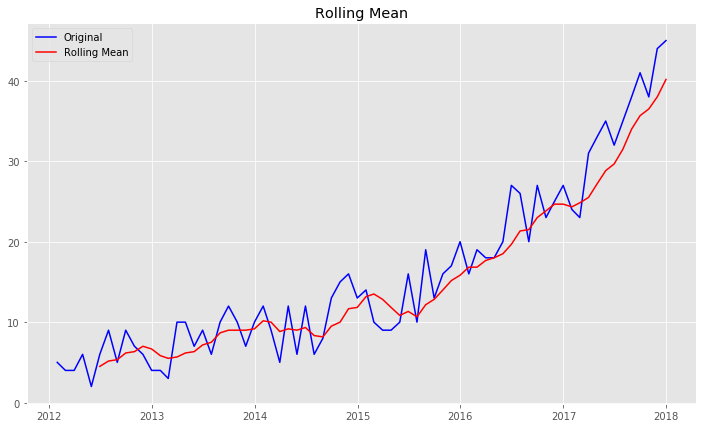

In [28]:
rolmean = ts.rolling(window = 6, center = False).mean()

fig = plt.figure(figsize=(12,7))
orig = plt.plot(ts, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean')
plt.show(block=False)

### Dickey-Fuller Test
Statistical test for testing stationarity; $H_0$ is that time series is **not** stationary

Doc Resource: http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

In [29]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(ts)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

(3.761375741674094, 1.0, 8, 63, {'1%': -3.5386953618719676, '5%': -2.9086446751210775, '10%': -2.591896782564878}, 314.84474355172597)


In [30]:
print(dfoutput)

Test Statistic                  3.761376
p-value                         1.000000
#Lags Used                      8.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


**We can interpret above results based on p-values of result.**

- p-value > 0.05 - This implies that time-series is non-stationary.<br/>
- p-value <=0.05 - This implies that time-series is stationary.

## Removing Trends 

Goal is to make the time series stationary to use most modeling techniques. When forecasting or predicting the future, most time series models assume that each point is independent of one another. The best indication of this is when the dataset of past instances is stationary. For data to be stationary, the statistical properties of a system do not change over time. This does not mean that the values for each data point have to be the same, but the overall behavior of the data should remain constant. The most common reasons for non-stationary series are seasonality and trends. 

### Log Transformation 

Transformations such as logarithms can help to stabilise the variance of a time series.

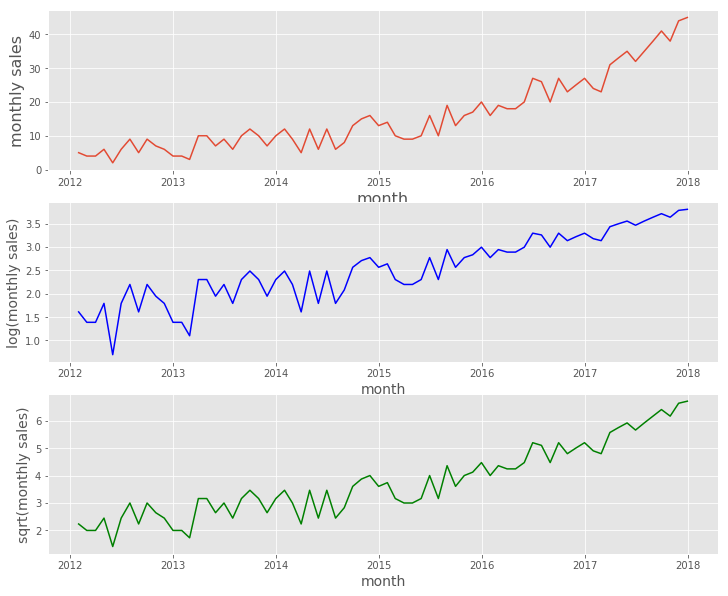

In [31]:
fig = plt.figure(figsize=(12,10))


# No transformation
plt.subplot(3, 1, 1)
plt.plot(ts)
plt.xlabel("month", fontsize=16)
plt.ylabel("monthly sales", fontsize=16)

# Log transformation (linear and heteroscedastic)
plt.subplot(3, 1, 2)
plt.plot(pd.Series(np.log(ts), index=index), color="blue")
plt.xlabel("month", fontsize=14)
plt.ylabel("log(monthly sales)", fontsize=14)

# Square root transformation 
plt.subplot(3, 1, 3)
plt.plot(pd.Series(np.sqrt(ts), index=index), color="green")
plt.xlabel("month", fontsize=14)
plt.ylabel("sqrt(monthly sales)", fontsize=14)


plt.show()

**Goal is to make this more linear; you can tell it's still not stationary. So what can we do?** 

### Subtract the Rolling Mean

Generally used to smooth out short-term fluctuations in time series data and highlight long-term trends

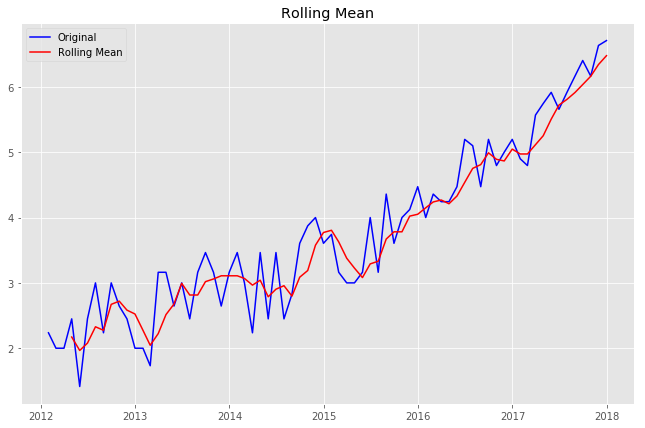

In [45]:
# Start with the square root transform
data_transform = pd.Series(np.sqrt(ts))

rolmean = data_transform.rolling(window = 4).mean()
fig = plt.figure(figsize=(11,7))
orig = plt.plot(data_transform, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean')
plt.show(block=False)

In [33]:
# Subtract the moving average from the original data and check head for Nans
data_minus_rolmean = data_transform - rolmean

In [34]:
# Drop the NaN values from timeseries calculated above 
# (the first few values didn't have a rolling mean)
data_minus_rolmean.dropna(inplace=True)

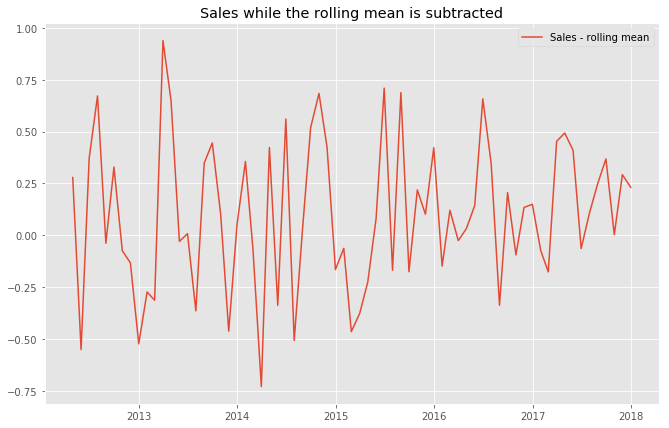

In [35]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_rolmean, label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

### Differencing

Note that the Google stock price was non-stationary in panel (a), but the daily changes were stationary in panel (b). This shows one way to make a non-stationary time series stationary —  create a new series in which each element is the difference between 2 consecutive elements in the original time series. This is known as differencing. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

The math works out to be: <br/>
$Z_t = X_{t-1} - X_t$<br/>
where:<br/>
$X_t$ - is an element of the original time series <br/>
$X_{t-1}$ - is the value of the time series one period in the past <br/>
$Z_t$ - is an element of the transformed time series

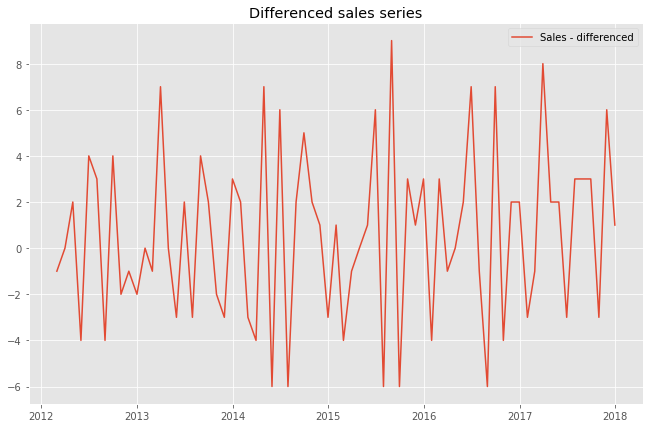

In [36]:
#Example with NYSE
data_diff = ts.diff(periods=1)

fig = plt.figure(figsize=(11,7))
plt.plot(data_diff,label='Sales - differenced')
plt.legend()
plt.title('Differenced sales series')
plt.show(block=False)

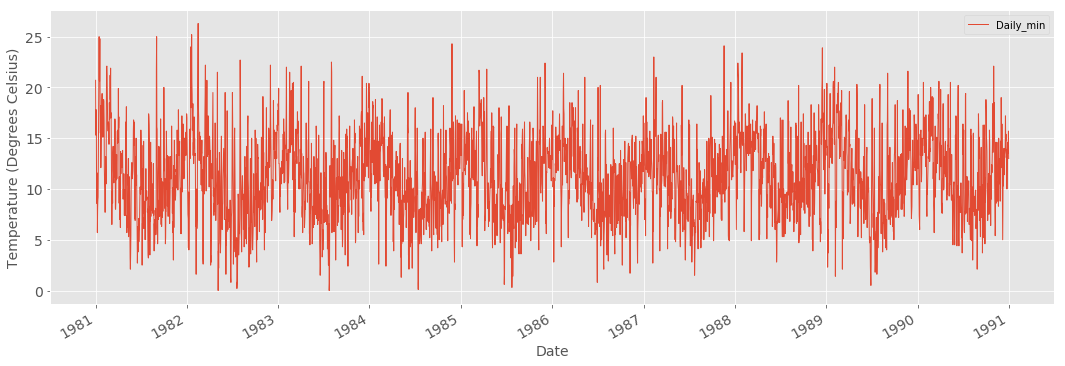

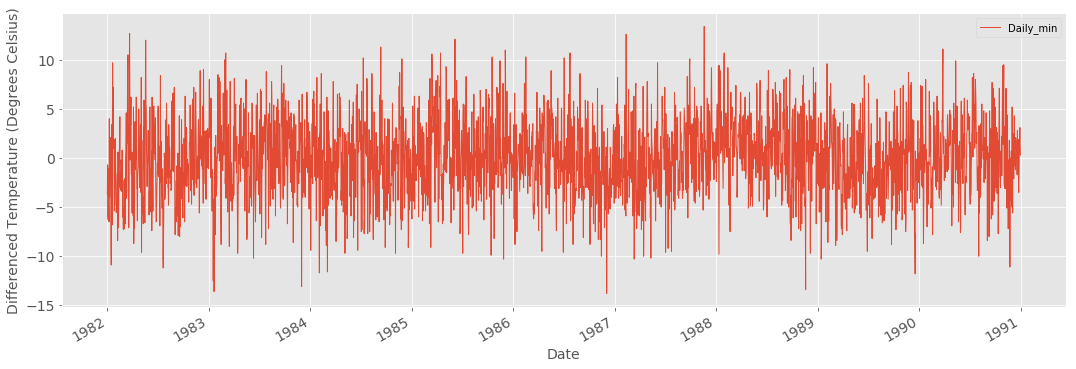

In [37]:
# Example - Temperature over a decade
data = pd.read_csv("min_temp.csv")
data.Date = pd.to_datetime(data.Date)
data.set_index('Date', inplace=True)

data.plot(figsize=(18,6), linewidth=1, fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Temperature (Degrees Celsius)', fontsize=14);

# Period is 365 days (each point)
data_diff = data.diff(periods=365)
data_diff.plot(figsize=(18,6), linewidth=1, fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Differenced Temperature (Degrees Celsius)', fontsize=14);

## Decomposing a Time Series with StatsModels 
Decomposition methods are based on an analysis of the individual componenets of a time series. The strength of each component is estimated seperately and then substituted into a model that exlains the behavior of the time series. Two most important decomposition methods are: 

> Multiplicative decomposition - a model that expresses the product of the 4 components of a time series. 
$y_t = TR_t * S_t * C_t * I_t$ <br/>
where: 

$y_t$ = the value of the time series at time t <br/>
$TR_t$ = the trend at time t <br/>
$S_t$ = the seasonal component at time t <br/>
$C_t$ = the cyclical compenent at time t <br/>
$I_t$ = the irregular component at time t



> Additive decomposition 




In [38]:
taxes_df = load_trend('taxes')
taxes_df.head()

,counts
2004-01,45
2004-02,54
2004-03,48
2004-04,56
2004-05,24


In [39]:
taxes_df.index = pd.to_datetime(taxes_df.index)

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(taxes_df['counts'])

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [41]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

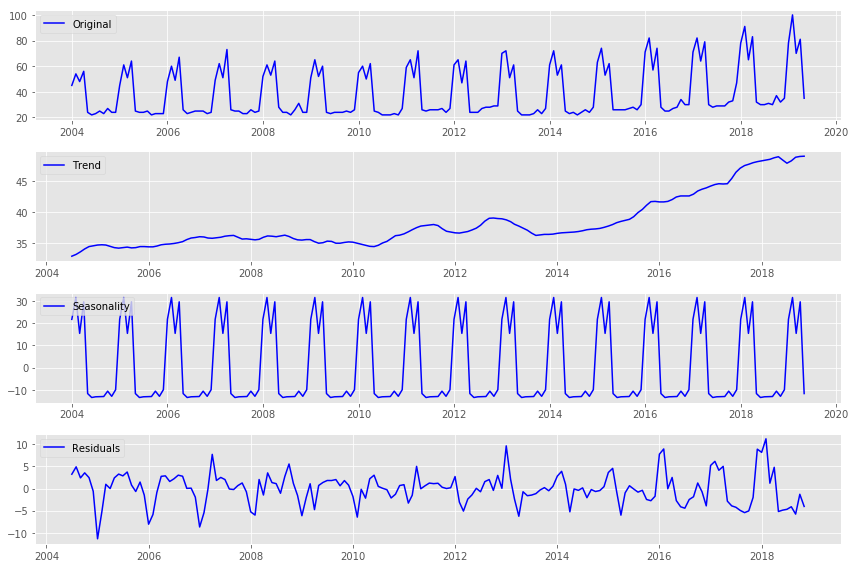

In [42]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

In [43]:
residual.mean()

-0.039666005291003725

For various techincal reasons that won't concern us here, some of the components of the decomposition have NANs at their heads and tails. But we can just use np.nansum() - a function that is used when we want to compute the sum of array elements over a given axis treating (NaNs) as zero.

In [44]:
myst = 0
for i in range(len(taxes_df['counts'])):
    myst += np.nansum(taxes_df['counts'][i] - trend[i] - seasonal[i] - residual[i])
myst

0.0

## Review

### Pre-processing

1. Make sure your dates/times are 'non-null datetime' objects not 'non-null objects'.
2. Set the datetime object as the index. Why? 
    - most important aspect of the data
    - many of the methods we use for analysis require this
3. Deal with missing data. What new options do we have available? 
    - ffill() - fills missing values with previous value 
    - bfill() - fills the missing values with the next valid entry
    CONS: Trend/seasonal components be influential with these methods
4. Use down/up sampling or slicing to manage the data that you want. What are the drawbacks to using down sampling or up sampling? 
* Downsampling drawback - Introduce missing data. You lose data.
* Upsampling drawback - Missing data. Increasing the size of the dataset

### Visualizations 
I strongly recommend completely the [learn.co lab on time series visuals](https://learn.co/tracks/module-4-data-science-career-2-1/big-data-deep-learning-and-natural-language-processing/section-37-working-with-time-series-data/visualizing-time-series-data-lab) 

### Trends 
- Upward
- Downward
- Exponential 
- Periodic 

### Stationarity
    - Rolling stats - checking to make sure parameters are constant over time(modeling assumption)
    - Dickey-Fuller Test 
    
### Removing Trends to satisfy assumptions 
1. Lof Trasnformations 
2. Subtract rolling average 
3. Differencing - Subtract off previous point values (lagging); essentially plots the difference from last point.

